# Optimisation and the Variational Quantum Eigensolver

## PennyLane

## Simple Optimisation

Here we will use PennyLane for what it has been designed for, Quantum Machine Learning. We will build a very simple optimisation problem and run it on the qubit simulator. Let's first build the QNode from the first exercise.

In [1]:
import pennylane as qml
from pennylane import numpy as npl

In [2]:
dev1 = qml.device("default.qubit", wires=1)

@qml.qnode(dev1, interface="autograd")
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    return qml.expval(qml.PauliZ(0))

PennyLane has in-built optimisers which can be used within the PennyLane language to optimise quantum circuits. Here we use the circuit from above and optimise $\phi$ and $\theta$ to get a circuit which rotates the state $\vert 0 \rangle$ to the $\vert 1 \rangle$ state. In terms of our measurement of the Pauli-Z operator, this means rotating from the measurement of $1$ to $-1$. 

Here we can define our cost function simply as the output of the circuit, as the measurement of the expectation value of the Pauli-Z operator is bounded between [-1, 1].

In [3]:
def cost(x):
    return circuit(x)

We now define some initial values which give us a result close to 1, thus the $\vert 0 \rangle$ state.

In [4]:
init_params = npl.array([0.0001, 0.0002], requires_grad=True)
print(cost(init_params))

0.9999999750000002


Note: here you must be careful not to use `np` and use `npl`. 

We now perform an optimisation to get create a circuit which rotates the qubit to the $\vert 1 \rangle$ state. 

In [5]:
### Initialise the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4) # we use a good lr

steps = 100

### Set the initial parameter values
params = init_params

### Perform optimisation, updating the parameters at each step
for i in range(steps):
    params = opt.step(cost, params)

    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))

print("Optimized rotation angles: {}".format(params))

Cost after step     5:  0.9999993
Cost after step    10:  0.9999791
Cost after step    15:  0.9993952
Cost after step    20:  0.9826807
Cost after step    25:  0.6130121
Cost after step    30: -0.6463199
Cost after step    35: -0.9959684
Cost after step    40: -0.9999755
Cost after step    45: -0.9999999
Cost after step    50: -1.0000000
Cost after step    55: -1.0000000
Cost after step    60: -1.0000000
Cost after step    65: -1.0000000
Cost after step    70: -1.0000000
Cost after step    75: -1.0000000
Cost after step    80: -1.0000000
Cost after step    85: -1.0000000
Cost after step    90: -1.0000000
Cost after step    95: -1.0000000
Cost after step   100: -1.0000000
Optimized rotation angles: [1.93016604e-16 3.14159265e+00]


We see that, to get a state of $\vert 1 \rangle$ we must rotate the system by $R_X(0)$ and $R_Y(\pi)$, which makes sense as

$$
\langle \psi \vert \sigma_z \vert \psi \rangle = \cos \phi \cos \theta.
$$

## The Variational Quantum Eigensolver

The Variational Quantum Eigensolver (VQE) is a hybrid algorithm that uses both classical computers and quantum computers to find the ground state of a given physical system. It has many uses in Quantum Chemistry and optimisation problems. Given an ansatz, the quantum device calculates the expectation value of a Hamiltonian, and a classical optimiser minimises the cost function.

Within VQE, the cost function is defined as the expectation value of the Hamiltonian computed in the trial state.

Here we will see how the VQE is encoded using as an example the Hamiltonian of a hydrogen molecule, $H_2$. 

### Building the Hamiltonian

Here we will use the in-built PennyLane functions to automatically build our Hamiltonian using the minimum basis set approximation. How one builds such a Hamiltonian is covered in the lectures.

We specify that we want a $H_2$ molecule, and give the nuclear coordinates in atomic units.

In [6]:
symbols = ["H", "H"]
coords  = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])

We can now build the Hamiltonian using the `molecular_hamiltonian()` function in PennyLane

In [7]:
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coords)
print("Number of qubits: ", qubits)
print("Hamiltonian:\n", H)

Number of qubits:  4
Hamiltonian:
   (-0.2427450126094144) [Z2]
+ (-0.2427450126094144) [Z3]
+ (-0.042072551947439224) [I0]
+ (0.1777135822909176) [Z0]
+ (0.1777135822909176) [Z1]
+ (0.12293330449299361) [Z0 Z2]
+ (0.12293330449299361) [Z1 Z3]
+ (0.16768338855601356) [Z0 Z3]
+ (0.16768338855601356) [Z1 Z2]
+ (0.17059759276836803) [Z0 Z1]
+ (0.1762766139418181) [Z2 Z3]
+ (-0.044750084063019925) [Y0 Y1 X2 X3]
+ (-0.044750084063019925) [X0 X1 Y2 Y3]
+ (0.044750084063019925) [Y0 X1 X2 Y3]
+ (0.044750084063019925) [X0 Y1 Y2 X3]


This function returns the number of qubits needed for the algorithm, corresponding to the number of spin orbitals, and the Hamiltonian, represented as a linear combination of Pauli operators. For this example, we just want to use the Hamiltonian as it is. For more information on how the Hamiltonian has been constructed, please see the PennyLane [documentation](https://docs.pennylane.ai/en/stable/code/api/pennylane.qchem.molecular_hamiltonian.html#pennylane.qchem.molecular_hamiltonian) and the [tutorial](https://pennylane.ai/qml/demos/tutorial_quantum_chemistry) on how to build molecular Hamiltonians.

### Implementing the VQE

We now use PennyLane just as before, but we will now integrate the quantum algorithms with classical optimisation. First, we load in a device just as before.

In [8]:
dev = qml.device("default.qubit", wires=qubits)

The VQE works on the variational theorem. The variational theorem states that for a time-independent Hamiltonian operator, any trial wave function will have an energy expectation value that is greater than or equal to the true ground-state wave function corresponding to the given Hamiltonian. Thus we can construct a trial state (here the HF function) and then minimise to find an approximation for the ground state.

We now need to set up our quantum circuit for our VQE. Here, we will go back to quantum chemistry and consider the state

$$
\vert \psi \rangle = \cos \frac{\theta}{2} \vert 1100 \rangle - \sin \frac{\theta}{2} \vert 0011 \rangle.
$$

The first term is a [Hartree-Fock (HF) state](https://en.wikipedia.org/wiki/Hartree–Fock_method), which describes the two electrons in the lowest energy state. The second term is the excitation state, where both electrons are in the excited state.


We can use the `hf_state` to encode these states on the circuit.

In [9]:
electrons = 2
hf        = qml.qchem.hf_state(electrons, qubits)

def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0,1,2,3])

@qml.qnode(dev, interface="autograd")
def cost(param):
    circuit(param, wires=range(qubits))
    return qml.expval(H)

Here we have build the circuit using the `qml.BasisState` which will construct the state $\vert 11 00 \rangle$ state on the device. We can of course do this using a series of `NOT` gates. 

The `qml.DoubleExcitation` function then applies an SU(2) rotation such that 

$$
\vert 1100 \rangle \rightarrow \cos \frac{\theta}{2} \vert 1100 \rangle - \sin \frac{\theta}{2} \vert 0011 \rangle,\\
\vert 0011 \rangle \rightarrow \cos \frac{\theta}{2} \vert 0011 \rangle + \sin \frac{\theta}{2} \vert 1100 \rangle.
$$

All other states are left unchanged. 

We then define the cost function as a QNode. Here, the cost function is the expectation value of the circuit with respect to the Hamiltonian. We can then apply a classical optimisation algorithm to minimise the Hamiltonian to its ground state.

In [10]:
opt   = qml.GradientDescentOptimizer(stepsize=0.4)

theta = npl.array(0.0, requires_grad=True)

We initialise the angle $\theta=0$, thus we have the circuit in the state $\vert 1100\rangle$.

We now carry out the optimisation:

In [11]:
### Store costs 
energy = [cost(theta)]

### Store angles
angle = [theta]

max_it = 100
conv_tol = 1e-6

for n in range(max_it):
    theta, prev_energy = opt.step_and_cost(cost, theta)
    
    energy.append(cost(theta))
    angle.append(theta)
    
    conv = np.abs(energy[-1] - prev_energy)
    
    if n % 2 == 0:
        print(f"Step = {n}, Energy = {energy[-1]:.8f} Ha")
        
    if conv <= conv_tol:
        break
        
print("\n" f"Final value of the ground state energy: {energy[-1]:.8f}")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

Step = 0, Energy = -1.12799983 Ha
Step = 2, Energy = -1.13466246 Ha
Step = 4, Energy = -1.13590595 Ha
Step = 6, Energy = -1.13613667 Ha
Step = 8, Energy = -1.13617944 Ha
Step = 10, Energy = -1.13618736 Ha
Step = 12, Energy = -1.13618883 Ha

Final value of the ground state energy: -1.13618883

Optimal value of the circuit parameter = 0.2089


We can now plot the results from our optimisation:

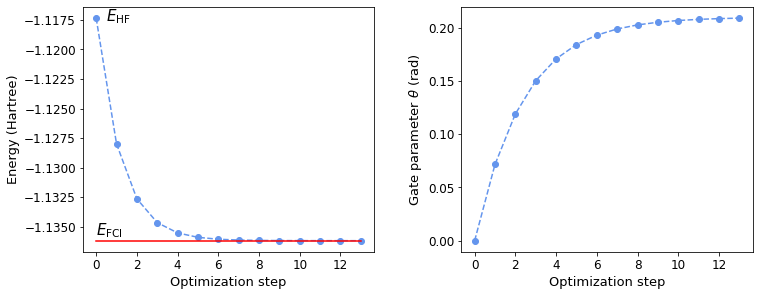

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "cornflowerblue", marker="o", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "cornflowerblue", marker="o", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()

We see that the VQE converges to $\theta=0.2089$, such that:

$$
\vert \psi \rangle = 0.994 \vert 1100\rangle - 0.104 \vert 00 11 \rangle,
$$

which is the ground state of the Hydrogen molecole in the minimal basis approximation.  

## Exercise:

Try building your own optimiser which can make any state on the quantum device. 

In [13]:
### Your code here

In [14]:
### Your code here

In [15]:
### Your code here

## Exercise:

Try building a VQE using a Hamiltonian of your choosing! 

In [ ]:
### Your code here